In [3]:
%load_ext dotenv
%dotenv 

In [20]:
from pymongo import MongoClient
import os
from datasets import Dataset, DatasetDict
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import math
from transformers import DataCollatorWithPadding
import numpy as np
import scipy.stats

In [5]:
ID = "1308026329"
MODEL_ID = "gpt2"

In [6]:
mongo_conn = MongoClient(os.environ["MONGO_CONN"])
db = mongo_conn.twitter  # our database

subjects_collection = db["subjects_collection"]
timelines_collection = db["timelines_collection"]
peers_collection = db["peers_collection"]

# User

In [7]:
subject = subjects_collection.find_one({"id": ID})
subject

{'_id': ObjectId('63de1efed7f30964c36bb079'),
 'created_at': '2013-03-27T16:58:10.000Z',
 'description': 'Forever reading too many books at once while trying to find the perfect red lip. 👌🏼 bookstagram @starless.reader 📚',
 'entities': {'url': {'urls': [{'start': 0,
     'end': 23,
     'url': 'https://t.co/UCwYGISyGI',
     'expanded_url': 'http://www.shewritesaboutbooks.com',
     'display_url': 'shewritesaboutbooks.com'}]},
  'description': {'mentions': [{'start': 96,
     'end': 105,
     'username': 'starless'}]}},
 'id': '1308026329',
 'location': 'Perth, Australia',
 'name': 'Ｓａｍａｎｔｈａ．💜',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/839815038844063744/rUZwGFvu_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 857,
  'following_count': 826,
  'tweet_count': 8750,
  'listed_count': 14},
 'url': 'https://t.co/UCwYGISyGI',
 'username': 'starless_reader',
 'verified': False,
 'verified_type': 'none',
 'timeline_tweets_count': 648}

# User tweets

In [8]:
user_tweets = list(timelines_collection.find({"author_id": ID, "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}))

for tweet, i in zip(user_tweets, range(10)):
    print(f"{i}.) {tweet['text']}")

0.) @PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH
1.) @PaperFury I did not ask to be called out like that 😂 https://t.co/lvHYjvAvgL
2.) The absolute best news to wake up to! 🥳🥳🥳🥳 https://t.co/SK3braPmNf
3.) 🥳🥳🥳🥳 https://t.co/yAtO3LsHMq
4.) @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
5.) A mood https://t.co/3ZEwWopeAY
6.) @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
7.) @PaperFury Still a ten 💁🏻‍♀️
8.) @PaperFury Omg 😂😂😂😂😂
9.) @shleyreads Ummmm gross?!


In [9]:
user_tweets[0]

{'created_at': '2023-01-16T13:25:49.000Z',
 'in_reply_to_user_id': '1381015116',
 'entities': {'mentions': [{'start': 0,
    'end': 10,
    'username': 'PaperFury',
    'id': '1381015116'}],
  'urls': [{'start': 56,
    'end': 79,
    'url': 'https://t.co/wRzxfTzTpH',
    'expanded_url': 'https://twitter.com/PaperFury/status/1614975937589968897',
    'display_url': 'twitter.com/PaperFury/stat…'}]},
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0,
  'impression_count': 19},
 'referenced_tweets': [{'type': 'quoted', 'id': '1614975937589968897'}],
 'possibly_sensitive': False,
 'lang': 'en',
 'author_id': '1308026329',
 'edit_history_tweet_ids': ['1614977223655829505'],
 'edit_controls': {'edits_remaining': 5,
  'is_edit_eligible': True,
  'editable_until': datetime.datetime(2023, 1, 16, 13, 55, 49)},
 'conversation_id': '1614977223655829505',
 'text': '@PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH',
 'id'

## Dataset

In [21]:
tweets_dataset = Dataset.from_list(user_tweets)

In [22]:
tweets_dataset

Dataset({
    features: ['created_at', 'in_reply_to_user_id', 'entities', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'lang', 'author_id', 'edit_history_tweet_ids', 'edit_controls', 'conversation_id', 'text', 'id', 'reply_settings', 'queried_at'],
    num_rows: 659
})

In [23]:
sample = tweets_dataset.select(range(500))

### Preprocess text

In [24]:
def remove_urls(x):
    return {"text": re.sub(r"http\S+", "", x["text"])}

def remove_extra_spaces(x):
    return {"text": " ".join(x["text"].split())}

In [25]:
updated_sample = sample.map(remove_urls).map(remove_extra_spaces)

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [26]:
for tweet, i in zip(updated_sample, range(10)):
    print(f"{i}.) {tweet['text']}")

0.) @PaperFury I’m taking this as a personal attack now. 😂😂
1.) @PaperFury I did not ask to be called out like that 😂
2.) The absolute best news to wake up to! 🥳🥳🥳🥳
3.) 🥳🥳🥳🥳
4.) @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
5.) A mood
6.) @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
7.) @PaperFury Still a ten 💁🏻‍♀️
8.) @PaperFury Omg 😂😂😂😂😂
9.) @shleyreads Ummmm gross?!


In [32]:
updated_sample = DatasetDict({
    "test": updated_sample.select(range(250)),
    "train": updated_sample.select(range(250, 500))
})

### Tokenization

In [33]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [34]:
text = updated_sample["test"][0]["text"]
text_tokenized = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(text_tokenized)
print(text)
print(text_tokenized)
print(ids)

@PaperFury I’m taking this as a personal attack now. 😂😂
['@', 'Paper', 'F', 'ury', 'ĠI', 'âĢ', 'Ļ', 'm', 'Ġtaking', 'Ġthis', 'Ġas', 'Ġa', 'Ġpersonal', 'Ġattack', 'Ġnow', '.', 'ĠðŁĺ', 'Ĥ', 'ðŁĺ', 'Ĥ']
[31, 42950, 37, 1601, 314, 447, 247, 76, 2263, 428, 355, 257, 2614, 1368, 783, 13, 30325, 224, 47249, 224]


In [35]:
decoded = tokenizer.decode(ids)
print(decoded)

@PaperFury I’m taking this as a personal attack now. 😂😂


In [36]:
tokenizer.truncation_side = "left"
tokenizer.truncation_side

'left'

In [37]:
# tokenizer.padding_side = "left"
tokenizer.padding_side

'right'

In [38]:
tokenizer.pad_token = tokenizer.eos_token

In [39]:
def tokenize_func(x):
    return tokenizer(x["text"], padding=True, return_tensors="pt")

In [40]:
tokenized_samples = updated_sample["test"].map(tokenize_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [41]:
for tweet in tokenized_samples.select(range(10)):
    print(tweet["input_ids"])
    print(tweet["attention_mask"])

[31, 42950, 37, 1601, 314, 447, 247, 76, 2263, 428, 355, 257, 2614, 1368, 783, 13, 30325, 224, 47249, 224, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[31, 42950, 37, 1601, 314, 750, 407, 1265, 284, 307, 1444, 503, 588, 326, 30325, 224, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 502

In [42]:
tokenized_samples.set_format(type="torch", columns=["input_ids", "attention_mask"])

Let's find out how long our longest tweet is!

In [43]:
l_text = len(tokenized_samples[0]["input_ids"]) # all samples are equal length after padding
l_max = tokenizer.model_max_length
l_ctxt = l_max - l_text
print("Longest user input: ", l_text)
print("Max context: ", l_ctxt)

Longest user input:  74
Max context:  950


### Model

In [44]:
model = AutoModelForCausalLM.from_pretrained(MODEL_ID)

#### Perplexity

In [45]:
nlls = []

for sample in tqdm(tokenized_samples):
    input_ids = sample["input_ids"]
    attention = sample["attention_mask"]
    target_ids = torch.where(attention == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        nlls.append(neg_log_likelihood)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:27<00:00,  2.85it/s]


In [46]:
ppl = torch.exp(torch.stack(nlls).mean())
h = torch.stack(nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl)
print("Entropy: ", h)

Perplexity:  tensor(214.4736)
Entropy:  tensor(7.7447)


##### Confidence interval

From https://discuss.pytorch.org/t/what-is-the-proper-way-to-compute-95-confidence-intervals-with-pytorch-for-classification-and-regression/139398/2

In [49]:
from torch import Tensor
def torch_compute_confidence_interval(data: Tensor,
                                           confidence: float = 0.95
                                           ) -> Tensor:
    """
    Computes the confidence interval for a given survey of a data set.
    """
    n = len(data)
    mean: Tensor = data.mean()
    # se: Tensor = scipy.stats.sem(data)  # compute standard error
    # se, mean: Tensor = torch.std_mean(data, unbiased=True)  # compute standard error
    se: Tensor = data.std(unbiased=True) / (n**0.5)
    t_p: float = float(scipy.stats.t.ppf((1 + confidence) / 2., n - 1))
    ci = t_p * se
    return mean, ci

In [63]:
mean, ci = torch_compute_confidence_interval(torch.stack(nlls), confidence=0.90)

print(f"Mean entropy (in nats): {mean} +/- {ci}")

print(f"--> Perplexity range: ({torch.exp(mean-ci)}, {torch.exp(mean+ci)})")

Mean entropy (in nats): 5.3681864738464355 +/- 0.12369419634342194
--> Perplexity range: (189.51953125, 242.7133026123047)


### Perplexity with context

Where context is 500 tokens long

#### User-conditioned

In [64]:
user_context = " ".join(updated_sample["train"]["text"])
user_context = tokenizer(user_context, truncation=True, return_tensors="pt")

In [65]:
user_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((user_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((user_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        user_nlls.append(neg_log_likelihood)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:20<00:00,  1.04s/it]


In [66]:
ppl_u = torch.exp(torch.stack(user_nlls).mean())
h_u = torch.stack(user_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_u)
print("Entropy: ", h_u)

Perplexity:  tensor(55.0325)
Entropy:  tensor(5.7822)


We have managed to bring down the perplexity of 229 down to 55!

In [67]:
mean, ci = torch_compute_confidence_interval(torch.stack(user_nlls), confidence=0.90)

print(f"Mean entropy (in nats): {mean} +/- {ci}")

print(f"--> Perplexity range: ({torch.exp(mean-ci)}, {torch.exp(mean+ci)})")

Mean entropy (in nats): 4.007923126220703 +/- 0.0043826536275446415
--> Perplexity range: (54.79179763793945, 55.274169921875)


#### Peer-conditioned

In [68]:
subject["id"]

peers_list = list(peers_collection.find({"mentioned_by.id": subject["id"]}, {"_id": 0}))

for peer in peers_list:
    mention = next( filter(lambda x: x["id"] == subject["id"] , peer["mentioned_by"]), None )
    print(f"username: {peer['username']} / mentioned {mention['num_mentions']} times / num tweets: {peer['timeline_tweets_count']}")

# There are 12 peers, so if we get 10 tweets each we should have more than enough...

peer_tweets = []
for peer in peers_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(10))
    peer_tweets.extend(user_tweets)

### Peers dataset

peers_dataset = Dataset.from_list(peer_tweets).shuffle(56)

for tweet in peers_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

#### Preprocess

peers_dataset = peers_dataset.map(remove_urls).map(remove_extra_spaces)

username: thatidiotfrank / mentioned 79 times / num tweets: 99
username: tea_readss / mentioned 51 times / num tweets: 96
username: PaperFury / mentioned 40 times / num tweets: 94
username: thecosyreader / mentioned 14 times / num tweets: 90
username: SundayLuxe / mentioned 9 times / num tweets: 28
username: shleyreads / mentioned 7 times / num tweets: 98
username: sofiaecasanova / mentioned 7 times / num tweets: 85
username: Explore_a_thon / mentioned 6 times / num tweets: 100
username: bookswithneeks / mentioned 5 times / num tweets: 97
username: ashmcl_ / mentioned 5 times / num tweets: 94
username: udeadah / mentioned 4 times / num tweets: 83
username: DateaBook / mentioned 4 times / num tweets: 100
@365177257: Now reading "The Big Dark Sky" by @deankoontz https://t.co/hMr4NBdO9T
@389514735: now we have attack on titan final season part 3 part 1 &amp; 2 🫠 https://t.co/p7BsxZ96XS
@365177257: Now reading "Mind Walker" by @TheKateDylan https://t.co/iiSZgdr4DH


  0%|          | 0/120 [00:00<?, ?ex/s]

  0%|          | 0/120 [00:00<?, ?ex/s]

In [69]:
peer_context = " ".join(peers_dataset["text"])
peer_context = tokenizer(peer_context, truncation=True, return_tensors="pt")

peer_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((peer_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((peer_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        peer_nlls.append(neg_log_likelihood)
        
        
ppl_p = torch.exp(torch.stack(peer_nlls).mean())
h_p = torch.stack(peer_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_p)
print("Entropy: ", h_p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:26<00:00,  1.07s/it]

Perplexity:  tensor(106.8835)
Entropy:  tensor(6.7399)


In [72]:
mean, ci = torch_compute_confidence_interval(torch.stack(peer_nlls), confidence=0.90)

print(f"Mean entropy (in nats): {mean} +/- {ci}")

print(f"--> Perplexity range: ({torch.exp(mean-ci)}, {torch.exp(mean+ci)})")

Mean entropy (in nats): 4.67173957824707 +/- 0.004394691903144121
--> Perplexity range: (106.41484069824219, 107.354248046875)


#### Rand user conditioned

In [70]:
rand_user_list = list(peers_collection.aggregate([ { "$sample": { "size": 15 } } ]))

for peer in rand_user_list:
    print(f"username: {peer['username']}")

rand_user_tweets = []
for peer in rand_user_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(10))
    rand_user_tweets.extend(user_tweets)

### Peers dataset

rand_user_dataset = Dataset.from_list(rand_user_tweets).shuffle(56)

for tweet in rand_user_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

#### Preprocess

rand_user_dataset = rand_user_dataset.map(remove_urls).map(remove_extra_spaces)

username: GamerJohn85
username: MhairiHunter
username: PphoenixK
username: LeoDougan
username: UrbanJerseyGuy
username: santiagomayer_
username: SuicideChrist
username: Komaniecki_R
username: dkirklambert
username: kumbdotcom
username: themishkoala
username: scotinoz
username: DlarsTrades
username: Tig_gordon
username: MeaghanBm
@1086353400646721536: @keirstyyy @BOOTeng27 Where have you been all of my life
@498942287: @IanRouth Sounds a lovely plan. I’m a support worker Ian.
@4327127414: We don’t sacrifice states around here bestie https://t.co/SZTnPVTE6m


  0%|          | 0/140 [00:00<?, ?ex/s]

  0%|          | 0/140 [00:00<?, ?ex/s]

In [71]:
rand_user_context = " ".join(rand_user_dataset["text"])
rand_user_context = tokenizer(rand_user_context, truncation=True, return_tensors="pt")

rand_user_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((rand_user_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((rand_user_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        rand_user_nlls.append(neg_log_likelihood)
        
        
ppl_ru = torch.exp(torch.stack(rand_user_nlls).mean())
h_ru = torch.stack(rand_user_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_ru)
print("Entropy: ", h_ru)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:30<00:00,  1.08s/it]

Perplexity:  tensor(78.3121)
Entropy:  tensor(6.2912)


In [73]:
mean, ci = torch_compute_confidence_interval(torch.stack(rand_user_nlls), confidence=0.90)

print(f"Mean entropy (in nats): {mean} +/- {ci}")

print(f"--> Perplexity range: ({torch.exp(mean-ci)}, {torch.exp(mean+ci)})")

Mean entropy (in nats): 4.3607025146484375 +/- 0.0035975289065390825
--> Perplexity range: (78.03089141845703, 78.5943832397461)


### Perplexity with increasing context

with context length = [0, 150, 300, 450, 600, 750, 900]

In [89]:
def entropy_calculator(tokenized_text, context, context_len=0, confidence=0.9):
    nlls = []
    
    for sample in tqdm(tokenized_text):
        # concatenate tensors
        input_ids = torch.cat((context["input_ids"][0][:context_len], sample["input_ids"]))
        attention_mask = torch.cat((context["attention_mask"][0][:context_len], sample["attention_mask"]))
        target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
            neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
            nlls.append(neg_log_likelihood)


    h_mean, h_err = torch_compute_confidence_interval(torch.stack(nlls), confidence)
    return h_mean, h_err

In [90]:
context_lengths = [0, 150, 300, 450, 600, 750, 900]

#### User-conditioned

In [91]:
user_entropies = []

for cl in context_lengths:
    h, err = entropy_calculator(tokenized_samples, user_context, context_len=cl)
    user_entropies.append((h, err))
    print(f"Context length: {cl} / H: {h} +/- {err}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.53it/s]


Context length: 0 / H: 5.3681864738464355 +/- 0.12369419634342194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:59<00:00,  2.08it/s]


Context length: 150 / H: 4.135119915008545 +/- 0.013863838277757168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:40<00:00,  1.55it/s]


Context length: 300 / H: 4.247203826904297 +/- 0.0077511644922196865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:01<00:00,  1.04it/s]


Context length: 450 / H: 4.315474033355713 +/- 0.005094702821224928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:40<00:00,  1.12s/it]


Context length: 600 / H: 3.566904067993164 +/- 0.0034976552706211805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:59<00:00,  1.44s/it]


Context length: 750 / H: 3.4916553497314453 +/- 0.0027571057435125113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:02<00:00,  1.69s/it]

Context length: 900 / H: 3.634037494659424 +/- 0.0023712830152362585


#### Peer-conditioned

In [92]:
peer_entropies = []

for cl in context_lengths:
    h, err = entropy_calculator(tokenized_samples, peer_context, context_len=cl)
    peer_entropies.append((h, err))
    print(f"Context length: {cl} / H: {h} +/- {err}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:03<00:00,  3.96it/s]


Context length: 0 / H: 5.3681864738464355 +/- 0.12369419634342194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:02<00:00,  2.04it/s]


Context length: 150 / H: 5.306085586547852 +/- 0.015615366399288177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:52<00:00,  1.45it/s]


Context length: 300 / H: 4.791631698608398 +/- 0.00703542260453105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:59<00:00,  1.05it/s]


Context length: 450 / H: 4.723911762237549 +/- 0.004986993502825499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:23<00:00,  1.05s/it]


Context length: 600 / H: 4.697792053222656 +/- 0.003697276348248124


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:02<00:00,  1.45s/it]


Context length: 750 / H: 4.633150577545166 +/- 0.0028229316230863333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:03<00:00,  1.69s/it]

Context length: 900 / H: 4.588040351867676 +/- 0.002426429418846965


#### Random user-conditioned

In [93]:
rand_user_entropies = []

for cl in context_lengths:
    h, err = entropy_calculator(tokenized_samples, rand_user_context, context_len=cl)
    rand_user_entropies.append((h, err))
    print(f"Context length: {cl} / H: {h} +/- {err}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.54it/s]


Context length: 0 / H: 5.3681864738464355 +/- 0.12369419634342194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:15<00:00,  1.84it/s]


Context length: 150 / H: 4.686762809753418 +/- 0.011571299284696579


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:07<00:00,  1.33it/s]


Context length: 300 / H: 4.773593902587891 +/- 0.006779051851481199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:04<00:00,  1.02it/s]


Context length: 450 / H: 4.302032947540283 +/- 0.004130820743739605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:15<00:00,  1.26s/it]


Context length: 600 / H: 4.349796772003174 +/- 0.003095970954746008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:52<00:00,  1.65s/it]


Context length: 750 / H: 4.527641773223877 +/- 0.0025459635071456432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:41<00:00,  1.84s/it]

Context length: 900 / H: 4.601700782775879 +/- 0.0022290311753749847


### Plotting helper
From https://stackoverflow.com/questions/69587547/continuous-error-band-with-plotly-express-in-python

In [94]:
import plotly.graph_objs as go

def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands."""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

In [108]:
entropies = []

for (h, err), cl in zip(user_entropies, context_lengths):
    data = {}
    data['h'] = h
    data["err"] = err
    data["context"] = "user"
    data["l_ctx"] = cl
    
    entropies.append(data)
    
for (h, err), cl in zip(peer_entropies, context_lengths):
    data = {}
    data["h"] = h
    data["err"] = err
    data["context"] = "peer"
    data["l_ctx"] = cl
    
    entropies.append(data)
    
for (h, err), cl in zip(rand_user_entropies, context_lengths):
    data = {}
    data["h"] = h
    data["err"] = err
    data["context"] = "rand_user"
    data["l_ctx"] = cl
    
    entropies.append(data)

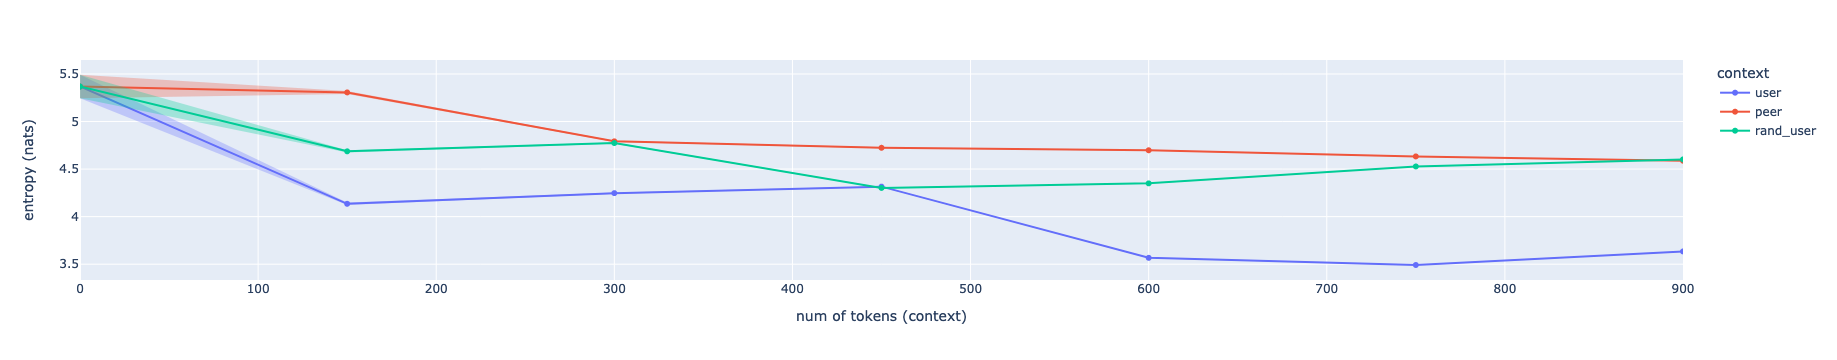

In [112]:
fig = line(data_frame=entropies, x="l_ctx", y="h", error_y="err", error_y_mode='bands', color="context", markers=True, hover_data=["err"])
fig.update_yaxes(title="entropy (nats)")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))

Unfortunately PPL(user|peer data) is roughly the same as PPL(user|rand user data)...

In [120]:
import pandas as pd

In [121]:
df = pd.DataFrame.from_dict(entropies)

In [123]:
df.head()

,h,err,context,l_ctx
0,tensor(5.3682),tensor(0.1237),user,0
1,tensor(4.1351),tensor(0.0139),user,150
2,tensor(4.2472),tensor(0.0078),user,300
3,tensor(4.3155),tensor(0.0051),user,450
4,tensor(3.5669),tensor(0.0035),user,600


In [128]:
df["ppl"] = torch.exp(torch.stack(df["h"].tolist()))

In [129]:
df["ppl"][:5]

0    214.473557
1     62.497086
2     69.909660
3     74.849098
4     35.406807
Name: ppl, dtype: float32

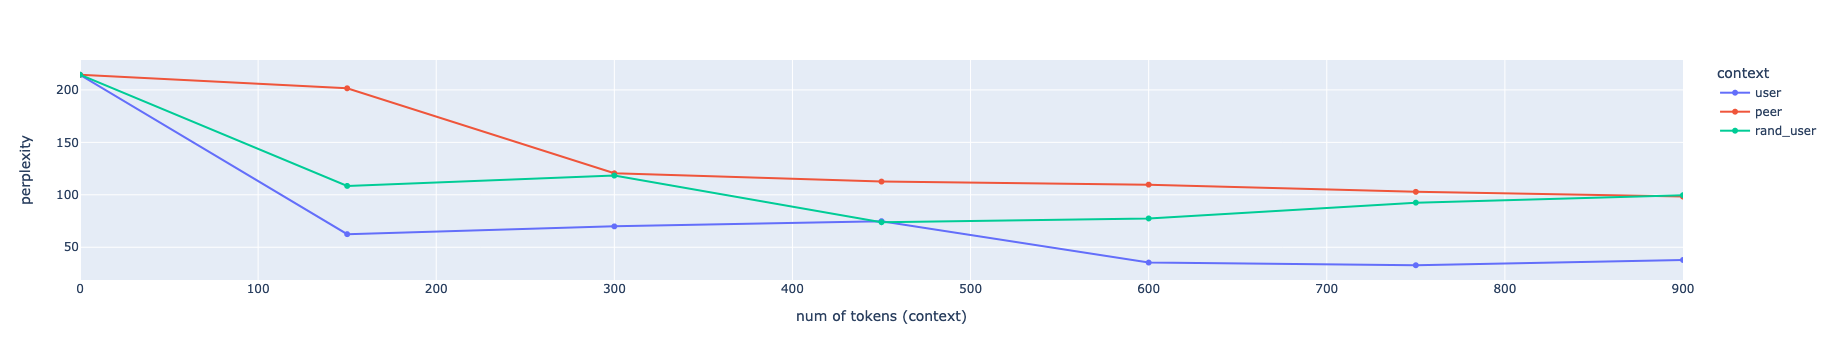

In [131]:
fig = px.line(df, x="l_ctx", y="ppl", color="context", markers=True)
fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))